# TP Intelligence Bio-Inspiré - Réseaux de neurones

## M2 IA Lyon 1 - Alexis Pister et Raphael Teitgen

L’objectif de ce TP est d’implémenter un réseau de neurone pour résoudre le problème de classification du jeu de données MNIST constitué d'images représentant des chiffres de 0 à 9. Le but est d'entrainer le modèle avec un jeu d'apprentissage puis de le tester avec un jeu de test, afin de déterminer le chiffre representé par l'image sans avoir accès au label. Nous allons commencé par implémenter un modèle simple que nous allons améliorer jusqu'à créer un perceptron multi-couches.

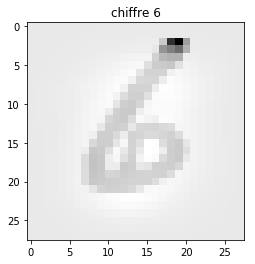

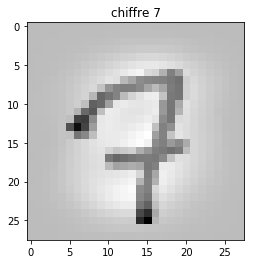

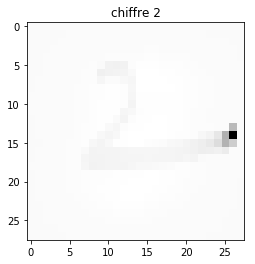

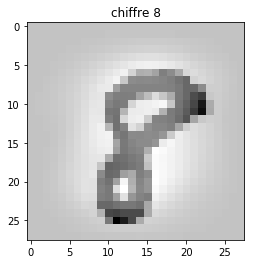

In [11]:
# Imports et code pour decompresser les donnees 
# (ecrit par Mathieu Lefort)
import gzip # pour décompresser les données
import pickle # pour désérialiser les données
import numpy
import numpy as np # pour pouvoir utiliser des matrices
import matplotlib.pyplot as plt # pour l'affichage
import torch,torch.utils.data
from torch.autograd import *
from torch.nn import *


# fonction qui va afficher l'image située à l'index index
def affichage(image,label):
    # on récupère à quel chiffre cela correspond (position du 1 dans label)
    label = numpy.argmax(label)
    # on crée une figure
    plt.figure()
    # affichage du chiffre
    # le paramètre interpolation='nearest' force python à afficher chaque valeur de la matrice sans l'interpoler avec ses voisines
    # le paramètre cmap définit l'échelle de couleur utilisée (ici noire et blanc)
    plt.imshow(image,interpolation='nearest',cmap='binary')
    # on met un titre
    plt.title('chiffre '+str(label))
    # on affichage les figures créées
    plt.show()
    

# nombre d'image lues à chaque fois dans la base d'apprentissage (laisser à 1 sauf pour la question optionnelle sur les minibatchs)
TRAIN_BATCH_SIZE = 1
# on charge les données de la base MNIST
data = pickle.load(gzip.open('mnist_light_CN.pkl.gz'),encoding='latin1')
# images de la base d'apprentissage
train_data = torch.Tensor(data[0][0])
# labels de la base d'apprentissage
train_data_label = torch.Tensor(data[0][1])
# images de la base de test
test_data = torch.Tensor(data[1][0])
# labels de la base de test
test_data_label = torch.Tensor(data[1][1])
# on crée la base de données d'apprentissage (pour torch)
train_dataset = torch.utils.data.TensorDataset(train_data,train_data_label)
# on crée la base de données de test (pour torch)
test_dataset = torch.utils.data.TensorDataset(test_data,test_data_label)
# on crée le lecteur de la base de données d'apprentissage (pour torch)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
# on crée le lecteur de la base de données de test (pour torch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


# Affichages
# 10 fois
# for i in range(0,10):
#     # on demande les prochaines données de la base
#     (_,(image,label)) = enumerate(train_loader).next()
#     # on les affiche
#     affichage(image[0,:].numpy(),label[0,:].numpy())


# NB pour lire (plus proprement) toute la base (ce que vous devrez faire dans le TP) plutôt utiliser la formulation suivante
# Affichage de 4 images
i = 0
for image,label in train_loader:
    if i < 4:
        affichage(image[0,:].numpy(),label[0,:].numpy())
        i += 1


## Partie 1 : Le perceptron

Nous allons commencer par coder l'algorithme du Perceptron. Le jeu de données ayant 10 labels, le model comprendra donc une couche de sortie de 10 neurones (chaque neurone correspond à un label). Chaque neurone sera connecté aux 784 entrées correspondant aux pixels de l'image par une matrice de poids.

In [42]:
%%time
#Parametres
N_entree = 785
N_neurones = 10
eta = 0.001
N_apprentissage = 300 #Nb d'images utilisées pour l'apprentissage


#Matrice des poids, lignes (i) : neurones, colonnes (j) : entrees
#On initialise tous les poids à 0.01
W = torch.ones(10, 785, dtype=torch.double) * 0.01
W[:, 0] = 0.01 #Biais

# Entrainement
for i, (image, label) in enumerate(train_loader):
    if i < N_apprentissage:
        #print(i)
        #Tensor representant l'image d'entree
        entree = image
        #On 'aplatit' le tableau
        entree = entree.flatten()
        #On ajoute le biais au debut de l'entree
        entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 
        
        #Calcul de la sortie des neurones
        Y = torch.mv(W, entree)        
        
        #Erreur
        Err = label.flatten().double() - Y
        #print(Err[i])
        
        #Mise a jour des poids
        for i in range(len(W)):
            for j in range(len(W[0])):
                W[i,j] = W[i,j] + eta * entree[j] * Err[i]
                
        #print(Y)
        

CPU times: user 3min 43s, sys: 4.17 s, total: 3min 47s
Wall time: 2min 49s


In [43]:
# On utilise notre reseau sur le jeu de test

#Nb d'images et compteur de positifs
Nb_positif = 0
Nb_images = len(test_loader.batch_sampler)

# Test
for i, (image, label) in enumerate(test_loader):
    #print(i)
    entree = image
    entree = entree.flatten()
    #On ajoute le biais au debut de l'entree
    entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree)) 
    
    #Calcul de la sortie des neurones
    Y = torch.mv(W, entree)
    #print(Y)
    #print(label)
    
    result_label = np.argmax(Y, axis=0)
    true_label = np.argmax(label.flatten(), axis=0)
    
    if result_label == true_label:
        Nb_positif += 1
        
        
print("La fréquence de bonne classification est de : ", Nb_positif / Nb_images)

La fréquence de bonne classification est de :  0.7628571428571429


Avec une valeur de $\eta$ de 0.001, une initialisation des poids uniforme à 0.01 et pour un jeu d'apprentissage comprenant 300 images nous obtenons un résultats d'environ 70% ce qui est plutot bon (76% obtenu au mieux sur quelques essais). Ajouter plus d'images à l'apprentissage semblent être inutile : nous avons essayé avec 500 images mais cela n'améliore pas la classification (73% de bon résultat pour un essai).

Nous avons remarqué que prendre un $\eta$ trop grand faisait vite exploser les valeurs des poids et des sorties des neurones. Avec un $\eta$ de 0.01 les valeurs explosait ayant pour conséquence un scrore moins bon d'environ 50%. Avec un pas d'apprentissage trop grand, il semble donc que le modèle n'arrive pas bien à converger vers un bon minimum local et diverge sur des valeurs des paramètres de plus en plus grands.

Nous avons ensuite fait varier l'initialisation des poids à 0.1 puis 1 mais cela ne semble pas affecter le résultat. Il semblerait que ce sont plus leurs valeurs relatives qui influencent le modèle que leurs valeurs intrinsèques.

## Partie 2 : Shallow network

Nous allons désormais implémenter l'algorithme du perceptron multi-couche avec une couche cachée. L'entrée n'est plus connectée directement aux neurones de sortie indiquant le label de l'image le plus probable, mais à une couche intermediaire de neurones. La fonction d'activation de cette couche correspond à la fonction sigmoide : $y = \frac{1}{1+\exp(-x)}$ ce qui ajoute de la non linéarité comparé au modèle précédent, censé améliorer la prise décision.
De plus, nous allons à partir de maintenant initialiser les poids de façon aleatoire autour d'un ordre de grandeur.

In [6]:
%%time
class Shallow_network:
    def __init__(self, train_loader, test_loader, taille_entree, taille_couche, nbLabels, poids):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.taille_entree = taille_entree #Taille de l'entree
        self.taille_couche = taille_couche #Taille de la couche cachee
        self.nbLabels = nbLabels
        
        # On rajoute une colonne pour les poids des biais
        self.W1 = poids*torch.randn(self.taille_couche, self.taille_entree+1, dtype=torch.double)
        self.W2 = poids*torch.randn(nbLabels, self.taille_couche+1, dtype=torch.double)
            
    # Train the model from train_set
    def training(self, eta = 0.005, nbImages = 200):
        for i, (image, label) in enumerate(self.train_loader):
            if i < nbImages:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))

                # Calcul des sorties des neurone de la couche cachée (sigmoide)
                y1 = (1 / (1 + torch.exp(-torch.mv(self.W1, entree))))
                # On rajoute un neurone pour le biais
                y1 = torch.cat((torch.tensor([1], dtype = torch.double), y1), 0)
                
                # Calcul de la sortie des neurones de la couche de sortie (lineaire)
                y2 = torch.mv(self.W2, y1)
                
                # Erreur de la couche de sortie
                Err2 = (label.flatten().double() - y2)
                # Erreur de la couche cachée
                Err1 = y1 * (1 - y1) * torch.mv(self.W2.t(), Err2)
                
                # Modification des poids
                dW2 = torch.ger(Err2, y1)
                dW1 = torch.ger(Err1[1:], entree)
                
                self.W2 += eta * dW2
                self.W1 += eta * dW1
                

           
    # Test the model with test set
    def run(self, Nb_images = 0):
        Nb_positif = 0
        if(Nb_images == 0):
            Nb_images = len(self.test_loader)
        for i, (image, label) in enumerate(self.test_loader):
            if i < Nb_images:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))

                # Calcul des sorties des neurone de la couche cachée (sigmoide)
                y1 = (1 / (1 + torch.exp(-torch.mv(self.W1, entree))))
                # On rajoute un neurone pour le biais
                y1 = torch.cat((torch.tensor([1], dtype = torch.double), y1), 0)

                # Calcul de la sortie des neurones de la couche de sortie (lineaire)
                y2 = torch.mv(self.W2, y1)

                result_label = np.argmax(y2, axis=0)
                true_label = np.argmax(label.flatten(), axis=0)

                if result_label == true_label:
                    Nb_positif += 1
                
        #Renvoie le score    
        return(Nb_positif / Nb_images)
                    

        
Sn = Shallow_network(train_loader, test_loader, 784, 50, 10, poids = 0.1)

# Training of the network
Sn.training(nbImages = 200, eta = 0.01)
print(Sn.run(0))

0.31142857142857144
CPU times: user 11.8 s, sys: 359 ms, total: 12.2 s
Wall time: 6.32 s


Différents hyper-paramètres influencent le modèle et peuvent faire changer drastiquement la qualité de la classification. Après avoir testé un petit peu le modèle nous avons trouvé des valeurs qui semblent assez bien fonctionner. Nous allons maintenant tester chacun des hyperparametres plus en détail un par un en mettant les valeurs pas trop absurdes trouvé précedemment.

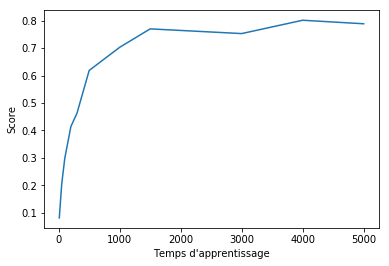

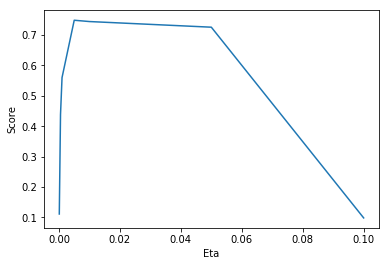

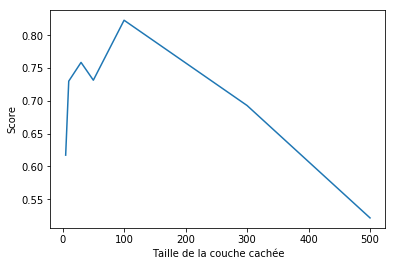

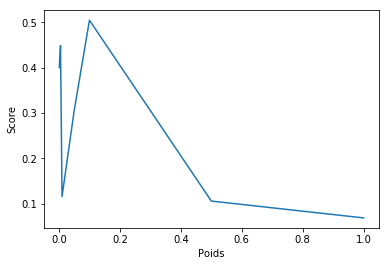

CPU times: user 26min 42s, sys: 48.2 s, total: 27min 30s
Wall time: 14min 3s


In [5]:
%%time
#Etude parametrique

# PAS DE TEMPS
T = [10, 50, 100, 200, 300, 500, 1000, 1500, 3000, 4000, 5000]
Scores = []
for t in T:
    Sn = Shallow_network(train_loader, test_loader, 784, 50, 10, 0.1)
    Sn.training(nbImages = t, eta=0.01)
    score = Sn.run(0)
    Scores.append(score)
plt.plot(T, Scores)
plt.xlabel("Temps d'apprentissage")
plt.ylabel("Score")
plt.show()



# # ETA
Eta = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
Scores = []
for eta in Eta:
    Sn = Shallow_network(train_loader, test_loader, 784, 50, 10, 0.1)
    Sn.training(nbImages=4000, eta=eta)
    score = Sn.run(0)
    Scores.append(score)
plt.plot(Eta, Scores)
plt.xlabel("Eta")
plt.ylabel("Score")
plt.show()

# # TAILLE COUCHE CACHEE
Ncouche = [5, 10, 30, 50, 100, 300, 500]
Scores = []
for N in Ncouche:
    Sn = Shallow_network(train_loader, test_loader, 784, N, 10, 0.1)
    Sn.training(nbImages = 4000, eta=0.01)
    score = Sn.run(0)
    Scores.append(score)
plt.plot(Ncouche, Scores)
plt.xlabel("Taille de la couche cachée")
plt.ylabel("Score")
plt.show()


# # INITIALISATION DES POIDS
Poids = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
Scores = []
for poids in Poids:
    Sn = Shallow_network(train_loader, test_loader, 784, 500, 10, poids)
    Sn.training(nbImages = 4000, eta=0.01)
    score = Sn.run(0)
    Scores.append(score)
plt.plot(Poids, Scores)
plt.xlabel("Poids")
plt.ylabel("Score")
plt.show()



On remarque que le modèle met plus de temps à appendre que le précédent. Cela est logique, étant donné qu'il y a 2 couches les variations des poids associé à l'entrée / couche cachée sont plus petites et les paramètres mettent donc plus de temps à converger vers un minimum local.  
Plus on augmente la taille du jeu d'apprentissage et plus le modèle est efficace jusqu'à $n = 4000$ avec un score de $0.80$. Le score baisse légèrement ensuite avec $n = 5000$, ce qui peut être vu comme un début de sur-apprentissage. 

Il est alors possible de mettre un pas d'apprentissage $\eta$ plus important. C'est bien ce qu'on remarque : les meilleurs valeurs se trouvent autour de $[ 0.005 - 0.01 ]$ avec un score associé proche de $0.75$

Le nombre de neurones optimal de la couche cachée semble être proche de 100, ce qui donne un score proche de $0.80$.

Enfin, on obient le meilleur score de 0.5 en initialisant les poids aux alentours de $0.1$ (Avec une couche cachée de 500 neurones, d'où le score aussi bas).

In [24]:
Sn = Shallow_network(train_loader, test_loader, 784, 100, 10, poids = 0.1)
Sn.training(nbImages = 4000, eta = 0.005)
print("Score maximal avec optimisation des parametres :", Sn.run(0))

Score maximal avec optimisation des parametres : 0.8085714285714286


## Partie 3 - Deep network

Nous allons dans cette partie implémenter l'algortihme du perceptron multi-couches avec plusieurs couches cachées. La descente de gradient pouvant être vite fastidieuse à coder nous allons nous aider du package autograd de Pytorch pour mettre à jour les poids.

In [44]:
# Partie 3 : Deep network
class Deep_network:
    def __init__(self, train_loader, test_loader, nbCouches, nbLabels, taille_entree, tailles_couches, poids):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.nbCouches = nbCouches
        self.nbLabels = nbLabels
        self.taille_entree = taille_entree #Taille de l'entree
        
        #Liste contenant les tailles de chaque couches
        self.tailles_couches = [self.taille_entree] + tailles_couches
        
        #liste ou chaque element correspond à une matrice des poids d'une couche
        self.W = []
        for i in range(len(self.tailles_couches[:-1])):
            # On rajoute une colonne correspondant aux poids des biais
            self.W.append(Variable(poids*torch.randn(self.tailles_couches[i+1],
                                                    self.tailles_couches[i] + 1,
                                                    dtype=torch.double),requires_grad=True))
            
            
    # Train the model from train_set
    def training(self, eta = 0.005, nbImages = 200):
        for i, (image, label) in enumerate(self.train_loader):
            if i < nbImages:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))
                
                #Liste comprenant les sorties de chaque couche
                Y = [entree]

                #Calcul de la sortie des neurones
                for i, W in enumerate(self.W):
                    if i == len(self.W) - 1:
                        # Pour calculer la couche de sortie (fonction lineaire)
                        y = torch.mv(W, Y[i])
                    else:
                        # Pour calculer les autres couches (fonction sigmoide)
                        y = (1 / (1 + torch.exp(-torch.mv(W, Y[i]))))
                        y = torch.cat((torch.tensor([1], dtype = torch.double), y), 0)
                        
                    Y.append(y)
                        
                
                Err = (label.flatten().double() - Y[-1]).pow(2).sum() * 0.5
                # Back propagation of error
                Err.backward()

                for W in self.W:
                    W.data -= eta * W.grad.data
                for W in self.W:
                    W.grad.data.zero_()

           
    # Test the model with test set
    def run(self, Nb_images = 0):
        Nb_positif = 0
        if(Nb_images == 0):
            Nb_images = len(self.test_loader)
        for i, (image, label) in enumerate(self.test_loader):
            if i < Nb_images:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))

                #entree = entree.unsqueeze(1)

                Y = [entree]

                #Calcul de la sortie des neurones
                for i, W in enumerate(self.W):
                    if i == len(self.W) - 1:
                        # Pour calculer la couche de sortie (fonction lineaire)
                        y = torch.mv(W, Y[i])
                    else:
                        # Pour calculer les autres couches (fonction sigmoide)
                        y = (1 / (1 + torch.exp(-torch.mv(W, Y[i]))))
                        y = torch.cat((torch.tensor([1], dtype = torch.double), y), 0)

                        #y1 = torch.cat((torch.tensor([1], dtype = torch.double).unsqueeze(1), y1), 0)
                    Y.append(y)

                result_label = np.argmax(Y[-1].detach(), axis=0)
                true_label = np.argmax(label.flatten(), axis=0)

                if result_label == true_label:
                    Nb_positif += 1
                
        #Renvoie le score    
        return(Nb_positif / Nb_images)
                    

        
# tailles_couches = [100, 50, 10]
# Dn = Deep_network(train_loader, test_loader, nbCouches = len(tailles_couches), nbLabels = 10,
#                   taille_entree = 784, tailles_couches = tailles_couches, poids = 0.1)

# # Training of the network
# Dn.training(nbImages = 10000, eta = 0.01)
# # Test
# print(Dn.run())

Ce modèle compte un paramètre de plus que le précédent qui est le nombre de couches cachées. Le nombre d'hyper-paramètres étant conséquent, nous allons essayer de réfléchir intelligement sur les valeurs à choisir.  
Plus on augmente le nombre de couches et plus le nombre de paramètres devient important et moins les variations des poids sont grandes sur les premières couches. On peut alors penser que plus on augmente le nombre de couches, plus il faut un temps d'apprentissage et un $\eta$ important (mais pas trop grand non plus pour ne pas dépasser un minimum local !).  
D'après des recherches complémentaire, il y a une hypothèse forte que le nombre de neurones au sein d'une couche cachée est compris entre les nombres de neurones des couches l'entourant. Nous allons donc tester ces hyper-paramètres sur 3 modèles possédant respectivement 2, 3 et 4 couches cachées vérifiant cette hypothèses.

DIMENSIONS DES COUCHES :  [100, 30, 10]


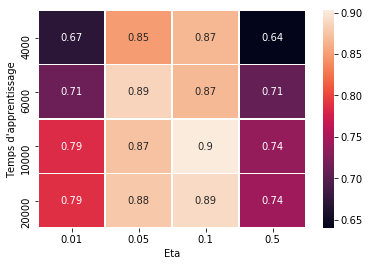

DIMENSIONS DES COUCHES :  [200, 100, 50, 10]


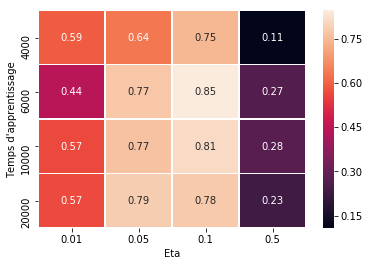

DIMENSIONS DES COUCHES :  [300, 150, 70, 30, 10]


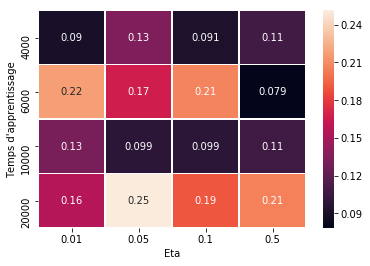

CPU times: user 2h 43min 27s, sys: 7min 12s, total: 2h 50min 40s
Wall time: 59min 37s


In [14]:
%%time
import seaborn as sns
# Chaque liste correspond à un modele, les nombres correspondent à la taille des couches
LAYERS = [[100, 30, 10], [200, 100, 50, 10], [300, 150, 70, 30, 10]]

T = [4000, 6000, 10000, 20000]
Eta = [0.01, 0.05, 0.1, 0.5]
grid = np.empty((len(T), len(Eta)))


#Test de eta et temps
for layers in LAYERS:
    print("DIMENSIONS DES COUCHES : ", layers)
    for i,t in enumerate(T):
        for j,eta in enumerate(Eta):
            Dn = Deep_network(train_loader, test_loader, nbCouches = len(layers), nbLabels = 10,
                  taille_entree = 784, tailles_couches = layers, poids = 0.1)
            Dn.training(nbImages = t, eta = eta)
            score = Dn.run(Nb_images = 0)
            grid[i][j] = score

    sns.heatmap(grid, linewidth = 0.5, annot = True, xticklabels= Eta, yticklabels= T)
    plt.xlabel("Eta")
    plt.ylabel("Temps d'apprentissage")
    plt.show()



Nous avons commencé par faire de la recherche paramétrique sur le temps et le pas d'apprentissage en même temps sur nos 3 modèles respectifs en initialisant les poids autour de 0.1, valeur qui semble marcher assez bien après quelques tests.  

On peut voir que c'est le modèle à 2 couches cachées qui fonctionnent le mieux, allant jusqu'à 90% de réussite avec un $\eta$ de 0.1 et un temps d'apprentissage de 10000.
Rajouter des couches n'a fait que baisser la performance : on obtient un score maximal de 0.85 avec 3 couches cachées ($\eta$ de 0.1 et temps d'apprentissage de 6000) et de seulement 0.25 avec 4 couches cachées ($\eta$ de 0.05 et temps d'apprentissage de 20000).
Globalement le temps d'apprentissage le plus efficace semble être aux alentours de 6000 et 10000 et le pas d'apprentissage à 0.1, qui sont des valeurs plus importante que les modèle avec une ou sans couche cachée.

Nous allons maintenant tester l'impact du poids avec les meilleurs hyper-paramètres trouvés jusque la.

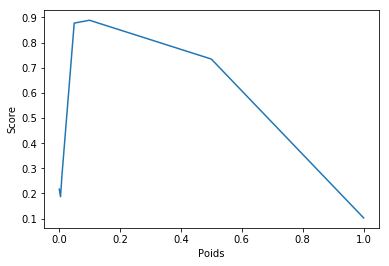

CPU times: user 24min 29s, sys: 1min 7s, total: 25min 37s
Wall time: 9min 21s


In [17]:
%%time
# # IMPACT DES POIDS
Poids = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
Scores = []
for poids in Poids:
    Dn = Deep_network(train_loader, test_loader, nbCouches = len(layers), nbLabels = 10,
                  taille_entree = 784, tailles_couches = [100, 30, 10], poids = poids)
    Dn.training(nbImages = 10000, eta=0.1)
    score = Dn.run(0)
    Scores.append(score)
plt.plot(Poids, Scores)
plt.xlabel("Poids")
plt.ylabel("Score")
plt.show()

Des poids initialisés aux alentours de 0.1 semble être la meilleurs option pour les autres hyper-parametres choisis, comme pour le modèle à une seule couche cachée. On peut alors obtenir un score d'environ 0.90.

### Partie 4 - Pour aller plus loin

Notre réseau de neurones marchent assez bien pour notre problème, mais il faut savoir que beaucoup de variantes existent dans la bibliographie. Par exemple, il existe d'autres techniques de descente de gradient, d'autres fonctions d'activations et même d'autres type de réseaux.

Nous allons dans cette partie tester d'autres fonctions d'activations pour voir l'impact sur la classification.

In [45]:
class Deep_network:
    def __init__(self, train_loader, test_loader, nbCouches, nbLabels, taille_entree, tailles_couches, poids, f):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.nbCouches = nbCouches
        self.nbLabels = nbLabels
        self.taille_entree = taille_entree #Taille de l'entree
        self.f = f # fonction d'activation
        
        #Liste contenant les tailles de chaque couches
        self.tailles_couches = [self.taille_entree] + tailles_couches
        
        #liste ou chaque element correspond à une matrice des poids d'une couche
        self.W = []
        for i in range(len(self.tailles_couches[:-1])):
            # On rajoute une colonne correspondant aux poids des biais
            self.W.append(Variable(poids*torch.randn(self.tailles_couches[i+1],
                                                    self.tailles_couches[i] + 1,
                                                    dtype=torch.double),requires_grad=True))
            
            
    # Train the model from train_set
    def training(self, eta = 0.005, nbImages = 200):
        for i, (image, label) in enumerate(self.train_loader):
            if i < nbImages:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))
                
                #Liste comprenant les sorties de chaque couche
                Y = [entree]

                #Calcul de la sortie des neurones
                for i, W in enumerate(self.W):
                    if i == len(self.W) - 1:
                        # Pour calculer la couche de sortie (fonction lineaire)
                        y = torch.mv(W, Y[i])
                    else:
                        # Pour calculer les autres couches (fonction sigmoide)
                        y = self.f(torch.mv(W, Y[i]))
                        y = torch.cat((torch.tensor([1], dtype = torch.double), y), 0)
                        
                    Y.append(y)
                        
                Err = (label.flatten().double() - Y[-1]).pow(2).sum() * 0.5
                # Back propagation of error
                Err.backward()

                for W in self.W:
                    W.data -= eta * W.grad.data
                for W in self.W:
                    W.grad.data.zero_()

           
    # Test the model with test set
    def run(self, Nb_images = 0):
        Nb_positif = 0
        if(Nb_images == 0):
            Nb_images = len(self.test_loader)
        for i, (image, label) in enumerate(self.test_loader):
            if i < Nb_images:
                #Tensor representant l'image d'entree
                entree = image
                #On 'aplatit' le tableau
                entree = entree.flatten()
                #On ajoute le biais au debut de l'entree
                entree = torch.tensor([torch.tensor(1.0, dtype = torch.double)] + list(entree))

                #entree = entree.unsqueeze(1)

                Y = [entree]

                #Calcul de la sortie des neurones
                for i, W in enumerate(self.W):
                    if i == len(self.W) - 1:
                        # Pour calculer la couche de sortie (fonction lineaire)
                        y = torch.mv(W, Y[i])
                    else:
                        # Pour calculer les autres couches (fonction sigmoide)
                        y = self.f(torch.mv(W, Y[i]))
                        y = torch.cat((torch.tensor([1], dtype = torch.double), y), 0)

                    Y.append(y)

                result_label = np.argmax(Y[-1].detach(), axis=0)
                true_label = np.argmax(label.flatten(), axis=0)

                if result_label == true_label:
                    Nb_positif += 1
                
        #Renvoie le score    
        return(Nb_positif / Nb_images)
    

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))


for f in [sigmoid, torch.relu, torch.tanh]:
    Dn = Deep_network(train_loader, test_loader, nbCouches = len(layers), nbLabels = 10,
                  taille_entree = 784, tailles_couches = [100, 30, 10], poids = 0.1, f=f)
    Dn.training(nbImages = 10000, eta=0.1)
    score = Dn.run(0)
    print("Fonction", f.__name__)
    print(score)



Fonction sigmoid
0.88
Fonction relu
0.09857142857142857
Fonction tanh
0.10285714285714286
